<a href="https://colab.research.google.com/github/Rk2042/EmosenseCode/blob/main/SERProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import time
from tqdm import tqdm

In [18]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
![ -f Audio_Speech_Actors_01-24.zip ] && echo "File existed" || wget "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1" -O Audio_Speech_Actors_01-24.zip

File existed


In [20]:
![ -f "./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav" ] && echo "File existed" || unzip Audio_Speech_Actors_01-24.zip -d "./Audio_Speech_Actors_01-24/"

File existed


In [21]:
import os
import pandas as pd

RAV = "./Audio_Speech_Actors_01-24/"
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)


RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
RAV_df.columns = ['gender','emotion','labels']
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.emotion.value_counts()

neutral     288
angry       192
sad         192
disgust     192
happy       192
surprise    192
fear        192
Name: emotion, dtype: int64

In [22]:
RAV_df

,gender,emotion,labels,source,path
0,male,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-05-...
1,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...
2,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...
3,male,disgust,7,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-07-...
4,male,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-03-...
...,...,...,...,...,...
1435,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-08-...
1436,female,fear,6,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-06-...
1437,female,fear,6,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-06-...
1438,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-08-...


In [23]:
RAV_df = RAV_df[(RAV_df["emotion"]=="neutral") | (RAV_df["emotion"]=="happy") | (RAV_df["emotion"]=="sad") | (RAV_df["emotion"]=="angry")]

In [26]:
# RAV_df = RAV_df.sample(frac=0.1)
train_df = RAV_df.sample(frac=0.8)
test_df = RAV_df.drop(train_df.index)

In [27]:
train_df

,gender,emotion,labels,source,path
490,male,neutral,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_09/03-01-02-...
540,female,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_10/03-01-05-...
1227,male,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_21/03-01-05-...
966,male,neutral,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_17/03-01-02-...
1170,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_20/03-01-04-...
...,...,...,...,...,...
421,female,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_08/03-01-03-...
513,male,neutral,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_09/03-01-02-...
1207,male,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_21/03-01-03-...
1308,female,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_22/03-01-01-...


In [28]:
train_df["emotion"].value_counts()

neutral    235
angry      161
sad        148
happy      147
Name: emotion, dtype: int64

In [29]:
# Display the first data.
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

gender                                                  male
emotion                                              neutral
labels                                                     2
source                                               RAVDESS
path       ./Audio_Speech_Actors_01-24/Actor_09/03-01-02-...
Name: 490, dtype: object


In [30]:
!pip install datasets


In [31]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

In [32]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {1:0, 2:0, 3:1, 4:3, 5:2}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))

In [33]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametri

In [34]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [40]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 5

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = list()

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()

        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })

        # record the loss for each batch
        epoch_loss.append(loss.item())

    pbar.close()

    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/5


100%|██████████| 346/346 [02:38<00:00,  2.18it/s, Loss=0.021, Accuracy=0.849]


Epoch 2/5


100%|██████████| 346/346 [02:39<00:00,  2.17it/s, Loss=0.056, Accuracy=0.880]


Epoch 3/5


100%|██████████| 346/346 [02:39<00:00,  2.16it/s, Loss=0.110, Accuracy=0.884]


Epoch 4/5


100%|██████████| 346/346 [02:39<00:00,  2.17it/s, Loss=0.000, Accuracy=0.912]


Epoch 5/5


100%|██████████| 346/346 [02:39<00:00,  2.17it/s, Loss=0.394, Accuracy=0.939]


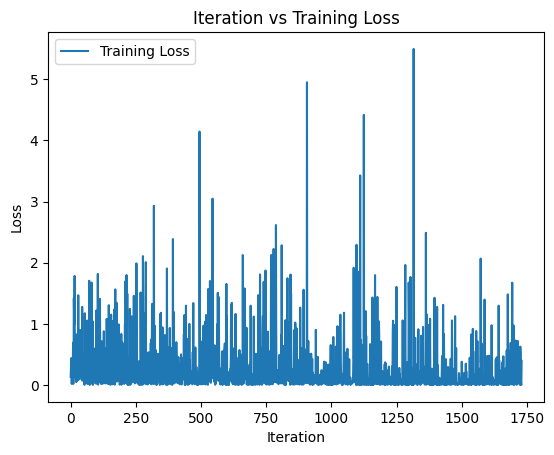

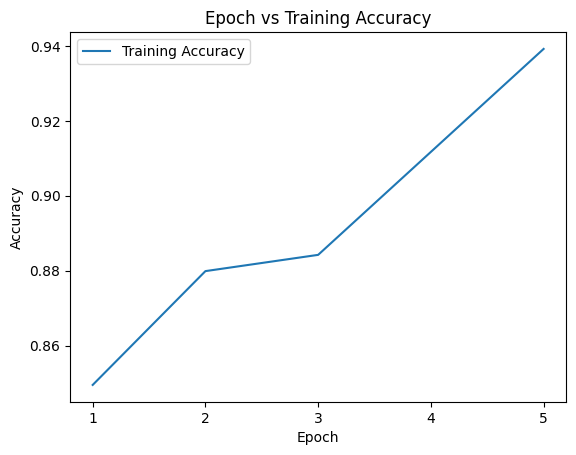

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()
plt.show()

In [42]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():

    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}

    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })

        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()

    pbar.close()

time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 173/173 [00:12<00:00, 14.05it/s, loss=8.835, accuracy=0.867]


The final accuracy on the test dataset: 86.7052%


In [45]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]

df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions
df[df["emotion"]!=df["Model Prediction"]]

,index,gender,emotion,labels,source,path,Model Prediction
4,41,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...,neu
6,70,female,hap,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_02/03-01-03-...,neu
9,92,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_02/03-01-04-...,neu
11,128,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_03/03-01-04-...,neu
23,188,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_04/03-01-04-...,hap
25,210,female,hap,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_04/03-01-03-...,neu
30,241,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_05/03-01-04-...,neu
34,255,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_05/03-01-04-...,neu
51,412,male,hap,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_07/03-01-03-...,neu
60,494,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_09/03-01-04-...,neu


from matplotlib import pyplot as plt
_df_36['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_37['labels'].plot(kind='hist', bins=20, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_38.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_39.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_40.groupby('Model Prediction').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_41.plot(kind='scatter', x='index', y='labels', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['labels']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_42.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('labels')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['labels']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_43.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('emotion')):
  _plot_series(series, series_name, i)
  fig.legend(title='emotion', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('labels')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['labels']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_44.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model Prediction')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model Prediction', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('labels')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_45.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_46['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_47['labels'].plot(kind='line', figsize=(8, 4), title='labels')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['emotion'].value_counts()
    for x_label, grp in _df_48.groupby('gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gender')
_ = plt.ylabel('emotion')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Model Prediction'].value_counts()
    for x_label, grp in _df_49.groupby('emotion')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('emotion')
_ = plt.ylabel('Model Prediction')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_50['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_50, x='index', y='gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_51['emotion'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_51, x='index', y='emotion', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_52['Model Prediction'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_52, x='index', y='Model Prediction', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_53['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_53, x='labels', y='gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)